# Evaluating an Exam Using Ply

This notebook shows how we can use the package [`ply`](https://ply.readthedocs.io/en/latest/ply.html)
to implement a scanner.  Our goal is to implement a program that can be used to evaluate the results of an exam.  Assume the result of an exam is stored in the string `data` that is defined below:

In [1]:
data = '''Class: Algorithms and Complexity
          Group: TINF22AI1
          MaxPoints = 60
   
          Exercise:      1. 2. 3. 4. 5. 6.
          Jim Smith:     9 12 10  6  6  0
          John Slow:     4  4  2  0  -  -
          Susi Sorglos:  9 12 12  9  9  6
          1609922:       7  4 12  5  5  3
       '''

This data show that there has been a exam with the subject <em style="color:blue">Algorithms and Complexity</em>
in the group <em style="color:blue">TIT09AID</em>.  Furthermore, the equation
```
   MaxPoints = 60
```
shows that in order to achieve the best mark, <em style="color:blue">60</em> points would have been necessary.
    
There have been 6 different exercises in this exam and, in this small example,  only four students took part, namely *Jim Smith*, *John Slow*, *Susi Sorglos*, and some student that is only represented by their matriculation number.  Each of the rows decribing the results of the students begins with the name (or matriculation number) of the student followed by the number of points that they have achieved in the different exercises. Our goal is to write a program that is able to compute the marks for all students.

## Imports

We will use the package [ply](https://ply.readthedocs.io/en/latest/ply.html).
In particular, we will use the scanner generator that is provided by the module `ply.lex`.  
Furthermore, we will additionally use regular expressions to extract a number from a string.  
Therefore, we also have to import the module `re`. 

In [2]:
import ply.lex as lex
import re

## Auxiliary Functions

The function `mark(max_points, points)` takes two arguments:
- `points`     is the number of points achieved by the student whose mark is to be computed.
- `max_points` is the number of points that need to be achieved in order to get the best mark of $1.0$.
  
It is assumed that the relation between the mark of an exam and the number of points achieved in this exam is mostly linear and that a student who has achieved $50\%$ of `max_points` points will get the mark $4.0$, while a student who has achieved  $100\%$ of `max_points` points will get the mark $1.0$.  Therefore, the formula to calcuclate the grade is as follows:
$$ \textrm{grade} = 7 - 6 \cdot \frac{\texttt{points}}{\texttt{max\_points}} $$
However, the worst mark is $5.0$.  Therefore, if the mark would fall below that line, the `min` function assures that it is less or equal than $5.0$. Furthermore, the resulting number is rounded to one digit.

In [3]:
def mark(max_points, points):
    grade = 7 - 6 * points / max_points
    return round(min(5.0, grade), 1)

Lets test this function by plotting it.  To do this we have to install `matplotlib`.

In [4]:
!pip install matplotlib

In [5]:
import matplotlib.pyplot as plt

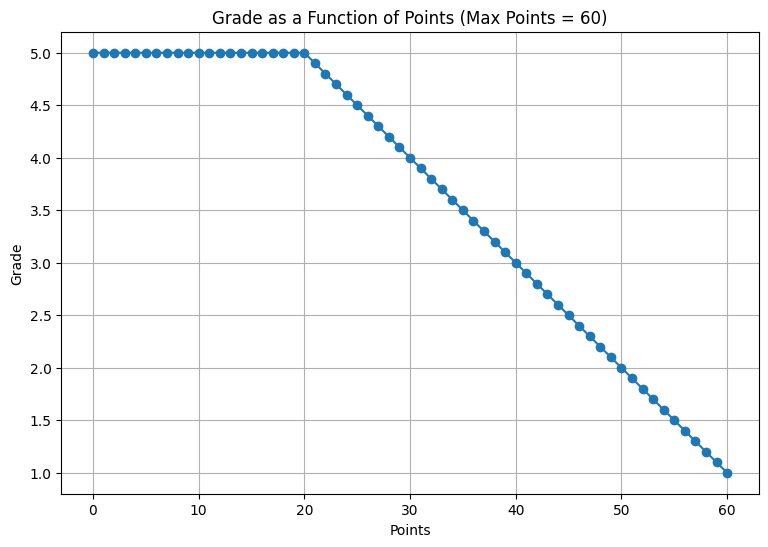

In [6]:
max_points = 60
points = [points for points in range(max_points+1)]
grades = [mark(max_points, points) for points in range(max_points+1)]

plt.figure(figsize=(9, 6))
plt.plot(points, grades, marker='o', linestyle='-')
plt.title('Grade as a Function of Points (Max Points = 60)')
plt.xlabel('Points')
plt.ylabel('Grade')
plt.grid(True)
plt.show()

## Token Declarations

We begin by <em style="color:blue">declaring</em> the list of tokens.  Note that the variable `tokens` is a keyword of `ply` to define the names of the token classes.  In this case, we have declared six different tokens.
The <em style="color:blue">definitions</em> of these tokens are given later.
- `HEADER` will match the first two lines of the string `data` as well as the fifth line that begins with 
  the string `Exercise:`.  
- `MAXDEF` matches the line containing the definition of `MaxPoints`.
- `NAME` matches the name of a student.
- `MATRICULATION` matches the matriculation number of a student. 
  This number is supposed to have exactly 7 digits.
- `NUMBER` matches a natural number.
  This is used for the points.
- `IGNORE` is a token that will match an empty line.  For example, the fourth line in `data` is empty.
- `LINEBREAK` is a token that will match the newline character `\n` at the end of a line.

In [7]:
tokens = [ 'HEADER',        # r'[A-Za-z]+:.*\n'
           'MAXDEF',        # r'MaxPoints\s*=\s*[1-9][0-9]*'
           'NAME',          # r'[A-Za-z -]+:'
           'MATRICULATION'  # r'[0-9]{7}:'        
           'NUMBER',        # r'0|[1-9][0-9]*'
           'IGNORE',        # r'^[ \t]*\n'
           'LINEBREAK'      # r'\n'
         ]

In [8]:
print(data)

Class: Algorithms and Complexity
          Group: TINF22AI1
          MaxPoints = 60
   
          Exercise:      1. 2. 3. 4. 5. 6.
          Jim Smith:     9 12 10  6  6  0
          John Slow:     4  4  2  0  -  -
          Susi Sorglos:  9 12 12  9  9  6
          1609922:       7  4 12  5  5  3
       


## Token Definitions

Next, we need to provide the definition of the tokens.  One way to define tokens is via python functions.  
In this notebook we are only going to use these <em style="color:blue">functional token definitions</em>.
The <em style="color:blue">document string</em> of these functions is a <em style="color:blue">raw string</em> that contains the regular expression defining the semantics of the token.  The regular expression can be followed by code that is needed to further process the token.  The name of the function defining a token has to have the form `t_`**name**, where **name** is the name of the token as declared in the list `tokens`.

### The `HEADER` Token

The token `HEADER` matches any string that is made up of upper and lower case characters followed by a colon.  This colon may be followed by arbitrary characters.
The token extends to the end of the line and includes the terminating newline.

When the function `t_HEADER` is called it is provided with a token `t`.  This is an object that has four
attributes:
- `t.lexer` is an object of class `Lexer` that contains the scanner that was used to extract the token `t`.
  We are free to attach additional attributes to this `Lexer` object.
- `t.type` is  a string containing the type of the token.  For tokens processed in the function
  `t_HEADER` this type is always the string `HEADER`.
- `t.value` is the actual string matched by the token.
- `t.lexpos` is the position of the token in the input string that is scanned.

Furthermore, the lexer object has one important attribute:
- `t.lexer.lineno` is the line number.  However, it is our responsibility to update this variable
  by incrementing `t.lexer.lineno` every time we read a newline.

In the case of the token `HEADER` we need to increment the attribute `t.lineno`, as the regular expression contains a newline.

In [9]:
def t_HEADER(t):
    r'[A-Za-z]+:.*\n'
    t.lexer.lineno += 1

### The Token `MAXDEF`

The token `MAXDEF` matches a substring of the form `MaxPoints = 60`.  Note that the regular expression defining the semantics of this token uses the expression `\s*` to match the white space before and after the character `=`.  We cannot just write a blank here because `ply.lex` uses <em style="color:blue">verbose regular expressions</em> that may contain whitespace for formatting.  Hence a blank character "` `" inside a regular expression is silently discarded.
 
After defining the regular expression, the function `t_MAXDEF` has some <em style="color:blue">action code</em> that is used to extract the maximal number of points from the token value and store this number in the variable `t.lexer.max_points`.
`t.value` is the string that is matched by the regular expression.
We extract the maximum number of points using conventional Python regular expressions.  Furthermore, we initialize the student name, 
which is stored in `t.lexer.name`,  to the empty string.

In [10]:
def t_MAXDEF(t):
    r'MaxPoints\s*=\s*[1-9][0-9]*'
    t.lexer.max_points = int(re.findall(r'[1-9][0-9]*', t.value)[0])
    t.lexer.name       = ''

### The Token Name

The token `NAME` matches the *name* of a student, which is followed by a colon character `:`.  In general, a student name can be any sequence of letters that contains optional hyphens and blanks.  Note that it is not necessary to use `\s` inside a character range, as we can use a blank character instead.
Furthermore, note that the hypen `-` is the last character in the square brackets so it cannot be mistaken for the hyphen of a range.

Note that every name has to contain at least one space so that the definition of `NAME` and `HEADER` do not overlap.

The action code has to reset the variable `sum_points` that is stored in `lexer.sum_points`to `0`.

In [11]:
def t_NAME(t):
    r'[A-Za-z -]+:'
    t.lexer.name = t.value[:-1] # cut of and discard the colon
    t.lexer.sum_points = 0      # start counting

### The Token `MATRICULATION`

The token `MATRICULATION` matches a string consisting of seven digits.  These digits are followed by a colon.
Again we have to reset the variable `sum_points`.

In [12]:
def t_MATRICULATION(t):
    r'[0-9]{7}:'
    t.lexer.name = t.value[:-1] # cut of colon
    t.lexer.sum_points = 0      # start counting

### The Token `NUMBER`

The token `NUMBER` matches a natural number.  We have to convert the value, which is initially a *string* of digits, into an integer.  Furthermore, this value is then added to the number of points the current student has achieved in previous exercises.

In [13]:
def t_NUMBER(t):
    r'0|[1-9][0-9]*'
    t.lexer.sum_points += int(t.value)

### The Token `IGNORE`

The token `IGNORE` matches a line that contains only whitespace.  In order to keep track of line numbers we have to increment `lexer.lineno`.  However, we do not return a token at the end of the function.  Hence, if the input contains an empty line, this line is silently discarded.

In [14]:
def t_IGNORE(t):
    r'^[ \t]*\n'
    t.lexer.lineno += 1

### The Token `LINEBREAK`

The token `LINEBREAK` matches a single newline character `\n`.  If a student name is
currently defined, then we output the result for this student.  Note that we set `lexer.name` back to the empty string once we have processed the student.
This allows for empty lines between different students.

In [15]:
def t_LINEBREAK(t):
    r'\n'
    t.lexer.lineno += 1
    if t.lexer.name != '':
        n = t.lexer.name
        m = t.lexer.max_points
        p = t.lexer.sum_points
        print(f'{n} has {p} points and achieved the mark {mark(m, p)}.')
        t.lexer.name = ''

### Ignoring Characters

The string `t_ignore` specifies those characters that should be ignored.  Note that this string is **not** interpreted as a regular expression.  It is just a string of *single characters*.  These characters are allowed to occur as part of other tokens, but when they occur on their own and would otherwise generate a scanning error, they are silently discarded instead of triggering an error. 

In this example we ignore hyphens `-`, blanks ` `, and tab characters. Hyphens occur when a student has not attempted a given exercise.

In [16]:
t_ignore  = '- \t'

### Error Handling

The function `t_error` is called when a string at the beginning of the input that
has not yet been processed can not be matched by any of the regular expressions defined in the various tokens defined above.  In our implementation we print the first character that could not be matched, discard this character and continue.

In [17]:
def t_error(t):
    print(f"Illegal character '{t.value[0]}' at line {t.lexer.lineno}.")
    t.lexer.skip(1)

### Tricking Ply

The line below is necessary to trick `ply.lex` into assuming this program is part of an ordinary python file instead of being a *Jupyter notebook*.

In [18]:
__file__ = 'main'

### Generating the Scanner and Running It

The next line generates the scanner.

In [19]:
lexer = lex.lex(debug=True)

lex: tokens   = ['HEADER', 'MAXDEF', 'NAME', 'MATRICULATIONNUMBER', 'IGNORE', 'LINEBREAK']
lex: literals = ''
lex: states   = {'INITIAL': 'inclusive'}
lex: Adding rule t_HEADER -> '[A-Za-z]+:.*\n' (state 'INITIAL')
lex: Adding rule t_MAXDEF -> 'MaxPoints\s*=\s*[1-9][0-9]*' (state 'INITIAL')
lex: Adding rule t_NAME -> '[A-Za-z -]+:' (state 'INITIAL')
lex: Adding rule t_MATRICULATION -> '[0-9]{7}:' (state 'INITIAL')
lex: Adding rule t_NUMBER -> '0|[1-9][0-9]*' (state 'INITIAL')
lex: Adding rule t_IGNORE -> '^[ \t]*\n' (state 'INITIAL')
lex: Adding rule t_LINEBREAK -> '\n' (state 'INITIAL')
lex: ==== MASTER REGEXS FOLLOW ====
lex: state 'INITIAL' : regex[0] = '(?P<t_HEADER>[A-Za-z]+:.*\n)|(?P<t_MAXDEF>MaxPoints\s*=\s*[1-9][0-9]*)|(?P<t_NAME>[A-Za-z -]+:)|(?P<t_MATRICULATION>[0-9]{7}:)|(?P<t_NUMBER>0|[1-9][0-9]*)|(?P<t_IGNORE>^[ \t]*\n)|(?P<t_LINEBREAK>\n)'


Next, we feed an input string into the generated scanner.

In [20]:
lexer.input(data)

In order to scan the data that we provided in the last line, the function `scan` iterates
over all tokens generated by our scanner.

In [21]:
def scan(lexer):
    for t in lexer:
        pass

Finally, we can run the scanner.

In [22]:
scan(lexer)

Jim Smith has 43 points and achieved the mark 2.7.
John Slow has 10 points and achieved the mark 5.0.
Susi Sorglos has 57 points and achieved the mark 1.3.
1609922 has 36 points and achieved the mark 3.4.
